In [16]:
import pyFAI
import pyFAI.calibrant
import pyFAI.detectors
import os, glob, re
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
import ipywidgets as widgets
from tifffile import imread, imshow, imsave
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from matplotlib.widgets import Slider, Button
import yaml, tifffile
%matplotlib widget

def sum_everything(my_im1, my_im2, my_im3, use_mask_1, use_mask_2, use_mask_3, osetx = 27, osety = 27):
    """ Assuming im2 offset by -osetx, -osety, and im3 offset by +osetx, +osety """
    
    my_imsum = np.ones((my_im1.shape[0]+int(2*osetx), my_im2.shape[1]+int(2*osety),3))*np.nan

    my_imsum[osetx:-osetx,osety:-osety,0] = my_im1
    my_imsum[osetx:-osetx,osety:-osety,0][use_mask_1==1] = np.nan

    my_imsum[:-int(2*osetx),:-int(2*osety):,1] = my_im2
    my_imsum[:-int(2*osetx),:-int(2*osety):,1][use_mask_2==1] = np.nan

    my_imsum[int(2*osetx):,int(2*osety):,2] = my_im3
    my_imsum[int(2*osetx):,int(2*osety):,2][use_mask_3==1] = np.nan
    return np.nanmean(my_imsum,axis=2)

def image_sum():
    data_dir = tiff_base_path + "dark_sub/"
    meta_dir = tiff_base_path + "meta/"
    Data = []
    
    os.chdir(data_dir)
    Tiff, Meta = [], []
    for file in os.listdir(data_dir):
        if file.endswith(".tiff"):
            Tiff.append(file)
    #A.sort(key=lambda x: os.path.getmtime(x))
    for file in os.listdir(meta_dir):
        if file.endswith(".yaml"):
            Meta.append(file)
    Tiff.sort()
    Meta.sort()
    F_number = len(Tiff)
    print(F_number)
    print(len(Meta))

    File_Name_Prefix = folder_name = os.path.basename(tiff_base_path.rstrip('/'))
    sum_dir = os.path.join(data_dir, 'sum')
    os.makedirs(sum_dir, exist_ok=True)  # Create 'sum' directory if it doesn't exist
    
    
    # for i in range(1, F_number, 3):  # Iterate with a step of 3
    #     if (i+2) >= F_number:
    #         break
    for i in range(0, int(F_number/3)):
        
        im_spotA = imread(Tiff[i*3+0])
        im_spotB = imread(Tiff[i*3+1])
        im_spotC = imread(Tiff[i*3+2])
    
        with open(os.path.join(meta_dir, Meta[i*3]), 'r') as f:
            data = yaml.unsafe_load(f)
            T = data.get('more_info')['cryostat_A']
    
        full_imsum = sum_everything(im_spotC, im_spotB, im_spotA, use_mask_3, use_mask_2, use_mask_1, osety=27, osetx=27)
        
        # Save output file to the new 'sum' directory
        tifffile.imsave(f"{sum_dir}/{File_Name_Prefix}_Temperature_{T}_K_sum.tiff", full_imsum)
    print (i)
    print (*list(Tiff), sep='\n')


def pct_integration():
    i2d, q1d, chi1d = ai.integrate2d(img, binning, unit=UNIT,npt_azim=3600, polarization_factor=polarization, mask=mask0) # perform azimuthalintegration on one image to retain 2D information
    intrinsic_mask_unrolled,_,_ = ai.integrate2d(mask0, binning, unit=UNIT,npt_azim=3600, polarization_factor=polarization, mask=mask0)  #trasnform mask0 (base mask) to the same coordinate space and cast it as type bool
    #intrinsic_mask_unrolled = intrinsic_mask_unrolled.astype(bool) 
    outlier_mask_2d = np.zeros_like(i2d)     # Create an array to hold outlier mask

    # i2d, q2d, chi2d = ai.integrate2d(img, binning, unit=UNIT, npt_azim=3600, polarization_factor=polarization, mask=mask0)
    mask1 = np.array(i2d<1)*1
    
    for ii, dd in enumerate(i2d.T):
        low_limit, high_limit = np.percentile(dd, (ll,ul))
        outlier_mask_2d[:,ii] = np.any([dd<low_limit, dd>high_limit, intrinsic_mask_unrolled[:,ii]], axis=0)
    mask=outlier_mask_2d + mask1    
    outlier_mask_2d_masked =  ma.masked_array(i2d, mask=outlier_mask_2d + mask1)
    i1d = ma.mean(outlier_mask_2d_masked,axis=0)
    data = np.column_stack((q1d, i1d))
    #plt.plot(q2d, ma.mean(outlier_mask_2d_masked,axis=0))
    data_fn = directory + "/dark_sub/sum/" + str(a) + "_L" + str(ll)+ "_U" + str(ul) + "_percentile_masked_"+ str(UNIT) + ".dat"
    np.savetxt(data_fn, data) # Uncomment when the data is ready to be saved

    return i1d, i2d, q1d, chi1d

In [9]:
# Below stiches every three pilatus images in folders that end with 'PDF' in the tiff_base
# tiff_base_path = ('/nsls2/data/pdf/pdfhack/legacy/processed/xpdacq_data/user_data_Petkov_315831_79f731e2_2025-04-09-1101//tiff_base/')    
# tiff_base_path = '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/'
tiff_base_path = '/nsls2/users/clin1/Documents/pyfai_test/'
use_mask_1= np.load("/nsls2/data/pdf/pdfhack/legacy/processed/xpdacq_data/user_data_Frandsen_315944_8496f7ec_2025-04-12-1911//config_base/masks/Mask_pos1_ext_BS.npy") # This is mask we are applying befor mergin images
use_mask_2 = np.load("/nsls2/data/pdf/pdfhack/legacy/processed/xpdacq_data/user_data_Frandsen_315944_8496f7ec_2025-04-12-1911//config_base/masks/Mask_pos2_ext_BS.npy") # This is mask we are applying befor mergin images
use_mask_3 = np.load("/nsls2/data/pdf/pdfhack/legacy/processed/xpdacq_data/user_data_Frandsen_315944_8496f7ec_2025-04-12-1911//config_base/masks/Mask_pos3_ext_BS.npy") # This is mask we are applying befor mergin images

# Get all folders ending with ending with '_PDF'. Alternativelly if you want to select a perticalur folder Type the folder name instead of "*_PDF"
pdf_folders = glob.glob(tiff_base_path + "*_PDF/")
for item in pdf_folders:
    print(item)

for directory in pdf_folders:
    print(directory)
    tiff_base_path = directory
    image_sum()

/nsls2/users/clin1/Documents/pyfai_test/Ni_PDF/
/nsls2/users/clin1/Documents/pyfai_test/Ni_PDF/
3
3
0
Ni_PDF_20250410-124253_13e7b4_primary-dk_sub_image-0.tiff
Ni_PDF_20250410-124304_cb244b_primary-dk_sub_image-0.tiff
Ni_PDF_20250410-124313_9ae6a1_primary-dk_sub_image-0.tiff


/tmp/ipykernel_2582343/1973134724.py:30: RuntimeWarning: Mean of empty slice
  return np.nanmean(my_imsum,axis=2)
/tmp/ipykernel_2582343/1973134724.py:73: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(f"{sum_dir}/{File_Name_Prefix}_Temperature_{T}_K_sum.tiff", full_imsum)


In [10]:
ai = pyFAI.load("/nsls2/data/pdf/pdfhack/legacy/processed//xpdacq_data/user_data_Frandsen_315944_8496f7ec_2025-04-12-1911/config_base/merged_PDF/merged.poni" ) 
mask0 = np.load("/nsls2/data/pdf/pdfhack/legacy/processed//xpdacq_data/user_data_Frandsen_315944_8496f7ec_2025-04-12-1911/config_base/masks/stitched_2.npy")
binning = 5000
polarization = 0.99
UNIT = "q_A^-1"
ll = 1 # lower percentile for the q dependent mask
ul = 99  # Upper percentile for the q dependent mask


In [17]:
# Integrate applying a percentile + base mask and save 2 column data. Percentile masking remove outliers based on the intensity at each Q independently 
# tiff_base_path = '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/'
tiff_base_path = '/nsls2/users/clin1/Documents/pyfai_test/'
pdf_folders = glob.glob(tiff_base_path + "*_PDF/") # PDF folder selection
print(*pdf_folders, sep = '\n')

for directory in pdf_folders:
    print(directory)
    for file in os.listdir(directory + "/dark_sub/sum/"):
        if file.endswith(".tiff"):
            img = imread(directory + "/dark_sub/sum/" + file)
            print(file)
            a,b = os.path.splitext(file)
            i1d, i2d, q1d, chi1d = pct_integration()


/nsls2/users/clin1/Documents/pyfai_test/Ni_PDF/
/nsls2/users/clin1/Documents/pyfai_test/Ni_PDF/
Ni_PDF_Temperature_150.019_K_sum.tiff


In [18]:
i2d.shape

(3600, 5000)

In [20]:
i1d.shape

(5000,)

In [19]:
q1d.shape

(5000,)

In [15]:
chi2d.shape

(3600,)

In [36]:
ai

Detector Detector	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.665000e-11 m
SampleDetDist= 2.126147e-01 m	PONI= 3.928429e-02, 1.738006e-01 m	rot1=-0.006280  rot2=0.003199  rot3=0.000000 rad
DirectBeamDist= 212.620 mm	Center: x=1018.232, y=232.352 pix	Tilt= 0.404° tiltPlanRotation= 26.995° 𝛌= 0.167Å

In [26]:
ai.getPyFAI()

{'detector': 'Detector',
 'pixel1': 0.00017199999999999998,
 'pixel2': 0.00017199999999999998,
 'max_shape': (1733, 1529),
 'orientation': <Orientation.BottomRight: 3>,
 'dist': 0.21261470614314407,
 'poni1': 0.039284293269034154,
 'poni2': 0.17380055825783822,
 'rot1': -0.006280152543663196,
 'rot2': 0.0031992244842886453,
 'rot3': 1.4537912401028803e-09,
 'wavelength': 1.6650000000000002e-11}

In [30]:
md = ai.getPyFAI()
md.items()
for key, value in md.items():
    print(key, value)

detector Detector
pixel1 0.00017199999999999998
pixel2 0.00017199999999999998
max_shape (1733, 1529)
orientation Orientation.BottomRight
dist 0.21261470614314407
poni1 0.039284293269034154
poni2 0.17380055825783822
rot1 -0.006280152543663196
rot2 0.0031992244842886453
rot3 1.4537912401028803e-09
wavelength 1.6650000000000002e-11


In [47]:
type(md)

dict

In [45]:
import pandas as pd
def iq_saver(fn, df, md, header=['q_A^-1', 'I(q)']):
    with open(fn, mode='w', encoding='utf-8') as f:
        f.write('pyFai_poni_information_28ID1_NSLS2_BNL\n')
        for key, value in md.items():
            f.write(f'{key} {value}\n')
    # Now append the dataframe without a header
    df.to_csv(fn, encoding='utf-8', mode='a', header=header, index=False, float_format='{:.8e}'.format, sep=' ')

In [34]:
df = pd.DataFrame()
df['q'] = q1d
df['I'] = i1d

In [46]:
fn = '/nsls2/users/clin1/Documents/pyfai_test/Ni_PDF_test.csv'
iq_saver(fn, df, md)

In [32]:
# Integrate only applying a base_mask and save 2 column data) 
tiff_base_path = '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/'
pdf_folders = glob.glob(tiff_base_path + "*_PDF/")
#for item in pdf_folders:
#    print(item)

for directory in pdf_folders:
    print(directory)
    for file in os.listdir(directory + "/dark_sub/sum/"):
        #print(directory)
        if file.endswith(".tiff"):
            img = imread(directory + "/dark_sub/sum/" + file)
            a,b = os.path.splitext(file)
            x,y = ai.integrate1d(img, binning, mask=mask0, unit=UNIT, polarization_factor=polarization) 
            data = np.column_stack((x, y))
            np.savetxt(directory + "/dark_sub/sum/" + str(a) + ".dat", data)

/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/


In [39]:
col_data_path = glob.glob(os.path.join(tiff_base_path, '*_PDF', 'dark_sub', 'sum', '*.dat'))
col_data_path.sort()
col_data_path

['/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_21.4002_K_sum.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_21.4002_K_sum_L1_U99_percentile_masked_q_A^-1.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_24.9949_K_sum.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_24.9949_K_sum_L1_U99_percentile_masked_q_A^-1.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_30.0079_K_sum.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_30.0079_K_sum_L1_U99_percentile_masked_q_A^-1.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum/Ni_PDF_Temperature_35.0098_K_sum.dat',
 '/home/xf28id1/Documents/chenghung/pilatus_test/tiff_base/Ni_PDF/dark_sub/sum

In [40]:
import pandas as pd

In [47]:
T_21K_base_mask = pd.read_csv(col_data_path[0], names=['q', 'I(q)'], sep=' ')
T_21K_perc_mask = pd.read_csv(col_data_path[1], names=['q', 'I(q)'], sep=' ')

In [46]:
T_21K_base_mask

,q,I(q)
0,0.886337,776.888611
1,0.893083,778.093506
2,0.899829,778.093506
3,0.906575,776.075256
4,0.913321,779.883484
...,...,...
4995,34.582495,353.844604
4996,34.589241,339.525970
4997,34.595987,379.320618
4998,34.602733,413.124298


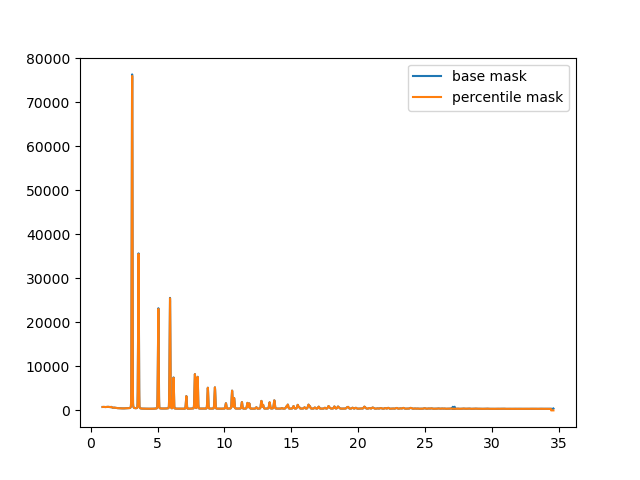

In [49]:
plt.plot()
plt.plot(T_21K_base_mask['q'], T_21K_base_mask['I(q)'], label='base mask')
plt.plot(T_21K_perc_mask['q'], T_21K_perc_mask['I(q)'], label='percentile mask')
plt.legend()
plt.show()